In [ ]:
Quantum Support Vector Machine

In [ ]:
!pip install pennylane

In [53]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.kernels.utils import kernel_matrix # import kernel_matrix utility function to obtain gram matrix

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

Load cancer dataset from scikit-learn

In [58]:
# Load breast cancer dataset
cancer = load_breast_cancer()

X = cancer['data']
y = cancer['target']

# Take only 8 first features and a sample of 200 elements
X = X[:200, :8]
y = y[:200]

# Scaling features in (0, 1)
scaler = MinMaxScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)

# train size 80%
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20)

Create 8 qubits device using 8 qubits and lightning.qubit plugin for better performance.
ZZfeatureMap from IBM is used to compose de ansatz.
We measure probabilities in all wires.

In [68]:
num_qubits = 8

dev = qml.device("lightning.qubit", wires=num_qubits)

def ZZFeatureMap(x, num_qubits):

    if num_qubits != len(x):
        raise Exception(f"Number of features must be equals to number of qubits, features {len(x)}, qubits {num_qubits}")

    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(2.0 * x[i], wires=i)

    for i in range(num_qubits):
        for j in range(i, num_qubits-1):
            qml.CNOT(wires=[i,j + 1])
            qml.RZ(2.0 * (np.pi - x[i]) * (np.pi - x[j+1]), wires=j + 1)
            qml.CNOT(wires=[i,j + 1])

@qml.qnode(dev)
def ansatz(x1, x2):
    ZZFeatureMap(x1, num_qubits)
    qml.adjoint(ZZFeatureMap)(x2, num_qubits)
    return qml.probs(wires=range(num_qubits))

Draw circuit in ASCCI art

In [ ]:
print(qml.draw(ansatz, level="device")(x_train[0], x_train[0]))

0: ──H──RZ(0.42)─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●─╭●───────────
1: ──H──RZ(0.41)─╰X──RZ(17.20)─╰X─│─────────────│──│─────────────│──│─────────────│──│────────────
2: ──H──RZ(0.42)──────────────────╰X──RZ(17.17)─╰X─│─────────────│──│─────────────│──│────────────
3: ──H──RZ(0.23)───────────────────────────────────╰X──RZ(17.73)─╰X─│─────────────│──│────────────
4: ──H──RZ(1.31)────────────────────────────────────────────────────╰X──RZ(14.56)─╰X─│────────────
5: ──H──RZ(0.58)─────────────────────────────────────────────────────────────────────╰X──RZ(16.71)
6: ──H──RZ(0.22)──────────────────────────────────────────────────────────────────────────────────
7: ──H──RZ(0.48)──────────────────────────────────────────────────────────────────────────────────

──╭●─╭●────────────╭●─╭●────────────╭●──────────────────────────────────────────────────────
──│──│─────────────│──│─────────────│──╭●────────────╭●─╭●────────────╭●─╭●────────────╭●─╭●
──│──│─────────────│─

Draw circuit in mpl format

(<Figure size 17500x900 with 1 Axes>, <Axes: >)

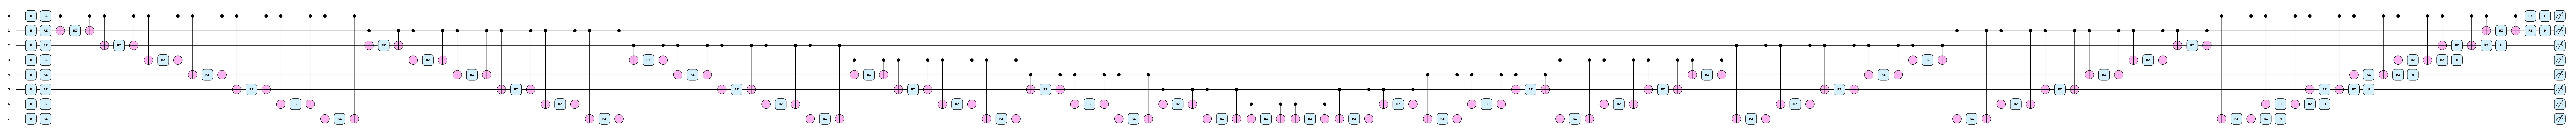

In [67]:
qml.draw_mpl(ansatz, level="device", style="pennylane")(x_train[0], x_train[0])

Because we are using kernel trick we need first element of probabilities that gives us the probability of getting all zeros.

In [45]:
def quantum_kernel(A, B):
  return kernel_matrix(A, B, lambda x1, x2: ansatz(x1,x2)[0])

Now we use scikit-learn to train our data but using a quantum kernel.

In [60]:
svc = svm.SVC(kernel=quantum_kernel)
svc.fit(x_train, y_train)

Fitted


Obtain prediction and accuracy_score (About 83%)

In [61]:
predictions = svc.predict(x_test)
acc = accuracy_score(predictions, y_test)

print(f"Accuracy score: {acc:.4f}")


Accuracy score: 0.8250


Comparing with classical support vector machine

In [65]:
classical_svc = svm.SVC()
classical_svc.fit(x_train, y_train)

preds = classical_svc.predict(x_test)
accs = accuracy_score(preds, y_test)

print(f"Accuracy score: {accs:.4f}")

Accuracy score: 0.8500
